In [1]:
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [2]:
#1. Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive = "/content/gdrive/MyDrive/207_project_files"
#KP: You'll see a pop-up from google to sign-in and connect to your drive



Mounted at /content/gdrive


In [3]:
#2. Copy archive.zip to gdrive to /home
#gdrive = "/content/gdrive/MyDrive"
!cp $gdrive/archive.zip /home

In [31]:
!rm -rf /home/data

In [32]:
#3. Unzip archive.zip to /home/data/full
!mkdir -p /home/data/full
!unzip /home/archive.zip -d /home/data/full/ > /dev/null

In [33]:
!mv /home/data/full/Driver\ Drowsiness\ Dataset\ \(DDD\) /home/data/train

!mv /home/data/train/Non\ Drowsy  /home/data/train/NonDrowsy

In [34]:
!ls /home/data/train/Drowsy | tail

ZC1349.png
ZC1350.png
ZC1351.png
ZC1352.png
ZC1353.png
ZC1354.png
ZC1355.png
ZC1356.png
ZC1357.png
ZC1358.png


In [35]:
!ls /home/data/train/NonDrowsy | tail

zc1697.png
zc1698.png
zc1699.png
zc1700.png
zc1702.png
zc1703.png
zc1704.png
zc1705.png
zc1706.png
zc1707.png


In [36]:
import os
import csv
import random
import string

def randomize_file_names (dir_path, mapping_file_name):


  # create a list of all the files in the directory
  files = os.listdir(dir_path)

  # create a dictionary to store the old and new file names
  file_mapping = {}

  # loop through each file in the directory
  for file in files:
      # generate a random string of 10 characters
      new_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
      # get the file extension
      ext = os.path.splitext(file)[1]
      # create the new file name with the random string and the original file extension
      new_file_name = new_name + ext
      # rename the file
      os.rename(os.path.join(dir_path, file), os.path.join(dir_path, new_file_name))
      # add the old and new file names to the dictionary
      file_mapping[file] = new_file_name

  # write the file mapping to a csv file
  with open(mapping_file_name, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['Old Name', 'New Name'])
      for key, value in file_mapping.items():
          writer.writerow([key, value])

randomize_file_names ("/home/data/train/NonDrowsy/", 'file_mapping_NonDrowsy.csv')
randomize_file_names ("/home/data/train/Drowsy/", 'file_mapping_Drowsy.csv')



In [37]:
!rm -rf /home/data/test/Drowsy
!rm -rf /home/data/test/NonDrowsy

!mkdir -p /home/data/test/Drowsy
!mkdir -p /home/data/test/NonDrowsy




In [38]:



import os
import random
import shutil

def split_test(percent, src_dir, dst_dir):

  # get a list of all the image files in the source directory
  image_files = [f for f in os.listdir(src_dir) if f.endswith('.jpg') or f.endswith('.png')]

  # calculate the number of images to move
  num_images_to_move = int(len(image_files) * percent)

  # randomly select the images to move
  images_to_move = random.sample(image_files, num_images_to_move)

  # move the selected images to the destination directory
  for image in images_to_move:
      src_path = os.path.join(src_dir, image)
      dst_path = os.path.join(dst_dir, image)
      shutil.move(src_path, dst_path)

split_test(0.3, '/home/data/train/Drowsy', '/home/data/test/Drowsy')
split_test(0.3, '/home/data/train/NonDrowsy', '/home/data/test/NonDrowsy')



In [39]:
!ls /home/data/test/Drowsy | tail

ZXYJSA7HJ6.png
ZY5TOWFC84.png
ZY93VDEOJ3.png
ZYE3K03YBX.png
ZYJHF8SJ1G.png
ZYKAT6D5AG.png
ZYS34ZZ0IW.png
ZYSVZ2RYVT.png
ZZKROFAGSJ.png
ZZNM6B45HJ.png


In [40]:
!ls /home/data/test/NonDrowsy | tail

ZX2WJKNT38.png
ZX5NN77LRN.png
ZX8JA0D0FP.png
ZXITMVDU6D.png
ZYB3UY3O46.png
ZYH80JIHIL.png
ZYRDO9NFXA.png
ZZ17QCLD0B.png
ZZNTOLSY4S.png
ZZPK9XSFIM.png


In [ ]:

#base_dir = root_dir + '207_project_files/data/'

In [ ]:
#!unzip '/content/gdrive/MyDrive/207_project_files/data/Driver Drowsiness Dataset (DDD).zip' -d '/content/gdrive/MyDrive/207_project_files/data/full/'

In [ ]:
#1. Mount gdrive

#2. Copy archive.zip to gdrive to /home
#3. Unzip archive.zip to /home/data/full
#4. Rename the full to train
#5. Randomize file names
#6. Move 30 percent files to test directory






# CNN Model

In [41]:
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [42]:
import matplotlib.pyplot as plt

# create empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])



In [43]:
X_RES = 32
Y_RES = 32

In [45]:
def build_model (train_model=False):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(Y_RES, X_RES, 3), padding='valid'))
    model.add(MaxPooling2D(2, 2))
    if train_model:
        model.add(Dropout(0.2))


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))


    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if train_model:
        model.add(Dropout(0.2))


    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    #optimizer = keras.optimizers.Adam(lr=0.9)
    optimizer = keras.optimizers.Adagrad(lr=0.8)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

    return model

In [46]:

model = build_model(train_model=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [47]:
train_dir = '/home/data/train/'


batch_size = 16

train_datagen = ImageDataGenerator(
            #rescale=1.0, #/ 255,  # Rescale pixel values to [0, 1]
            rotation_range=5,  # Rotate images by up to 20 degrees
            width_shift_range=0.2,  # Shift the width of the image by up to 20%
            height_shift_range=0.2,  # Shift the height of the image by up to 20%
            shear_range=0.2,  # Apply shear transformation
            zoom_range=0.2,  # Zoom in by up to 20%
            horizontal_flip=False,  # Flip images horizontally
            fill_mode='nearest',  # Fill in missing pixels with the nearest value
            validation_split=0.3
        )



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'

)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    color_mode='rgb'

)

Found 20480 images belonging to 2 classes.
Found 8776 images belonging to 2 classes.


Epoch 1/20
1280/1280 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.5449

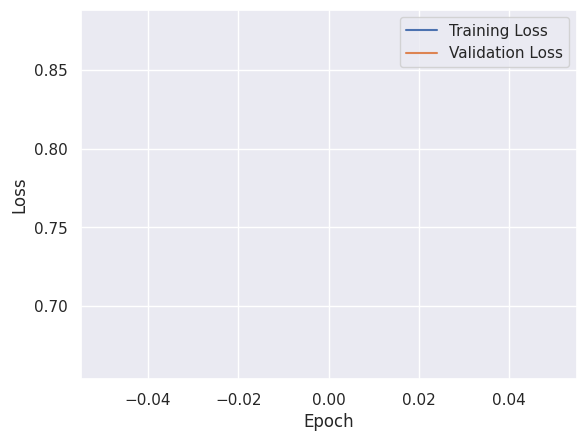

1280/1280 [==============================] - 155s 111ms/step - loss: 0.8776 - accuracy: 0.5449 - val_loss: 0.6642 - val_accuracy: 0.6046
Epoch 2/20
1280/1280 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5728

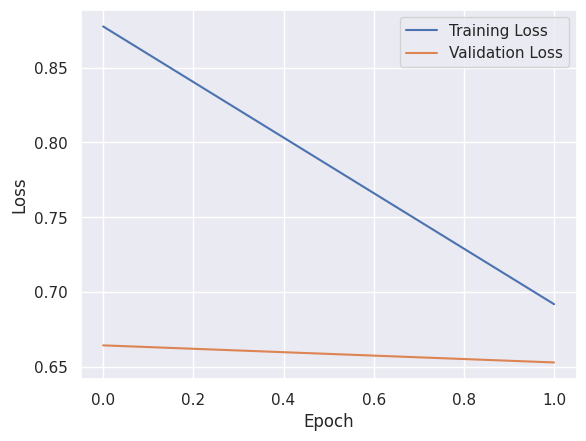

1280/1280 [==============================] - 120s 94ms/step - loss: 0.6918 - accuracy: 0.5728 - val_loss: 0.6528 - val_accuracy: 0.6420
Epoch 3/20
1280/1280 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6037

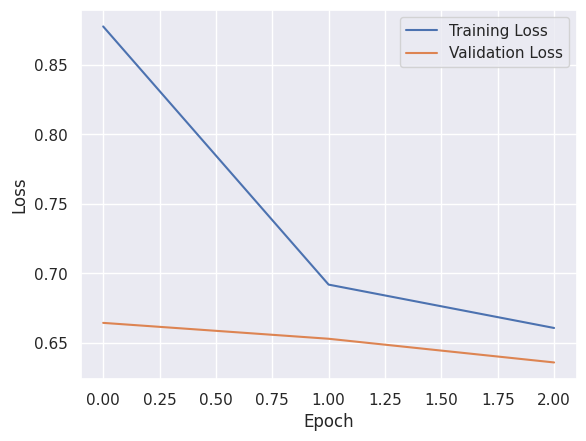

1280/1280 [==============================] - 123s 96ms/step - loss: 0.6606 - accuracy: 0.6037 - val_loss: 0.6357 - val_accuracy: 0.6387
Epoch 4/20
1280/1280 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.6215

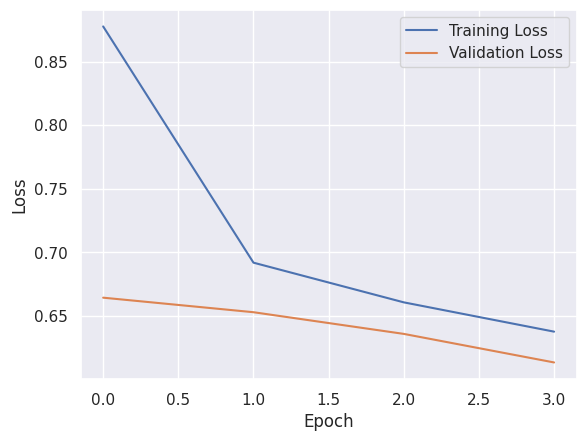

1280/1280 [==============================] - 122s 95ms/step - loss: 0.6375 - accuracy: 0.6215 - val_loss: 0.6133 - val_accuracy: 0.6714
Epoch 5/20
1279/1280 [============================>.] - ETA: 0s - loss: 0.6206 - accuracy: 0.6408

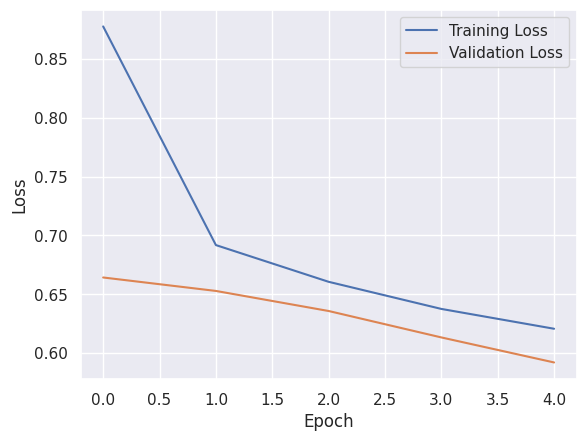

1280/1280 [==============================] - 124s 97ms/step - loss: 0.6206 - accuracy: 0.6406 - val_loss: 0.5920 - val_accuracy: 0.6991
Epoch 6/20
1280/1280 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.6720

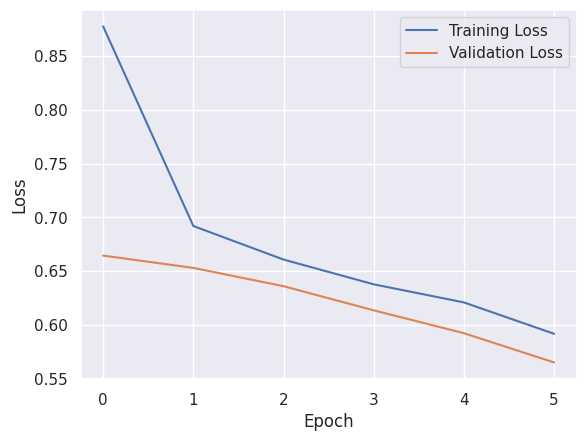

1280/1280 [==============================] - 134s 105ms/step - loss: 0.5914 - accuracy: 0.6720 - val_loss: 0.5647 - val_accuracy: 0.7286
Epoch 7/20
1267/1280 [============================>.] - ETA: 1s - loss: 0.5691 - accuracy: 0.6947

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[PlotLossCallback(), early_stopping])

In [ ]:
model.save('/home/dd_model.h5')

In [ ]:
test_dir = '/home/data/test/'

test_datagen = ImageDataGenerator(
            #srescale=1.0 / 255,  # Rescale pixel values to [0, 1]
        )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(X_RES, Y_RES),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    color_mode='rgb'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
#model = keras.models.load_model('dd_model.h5')

# This section is to test custom images

In [ ]:
import  pandas as pd
from IPython.display import display

#dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'

dir_path = '/Users/mayank/Programs/mids_ml/mids/DriverDrowsiness/data/test_img/'

def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(X_RES, Y_RES), color_mode='rgb')
    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions

i = 0
prediction_results = []
for file_name in os.listdir(dir_path):

    predictions = predict(model, dir_path+file_name)

    dp, fn = os.path.split(dir_path)
    prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
    i = i + 1
    if i == 100:
        break

df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])

#df = pd.DataFrame(prediction_results, columns=['Filename', '1', '2', '3', '4'])


display(df)

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.models import Model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most warnings

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Suppress TensorFlow v1.x warnings


def plot_conv_layers(model, img_path):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (X_RES, Y_RES))
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model's input shape

    # Get the output of each Conv2D layer
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict(img)
    layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

   # Plot the output of each layer in a 1x3 grid
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(activations[i][0, :, :, 0], cmap='gray')  # Displaying the 1st channel
        ax.set_title(layer_names[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Plot the convolved layers
plot_conv_layers(model, '/home/mayank/Pictures/Webcam/test/face_2.jpg')

plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/d0016.png')

plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/c0417.png')

plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/b0027.png')

plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/a1023.png')